In [1]:
from linares_plot import *
import statsmodels.formula.api as smf

In [2]:
%run "C:\\Users\\David\\Documents\\GitHub\\wm_distractor_filtering\\psychophysics\\Funciones.ipynb"

In [3]:
df_psy = pd.read_csv('C:\\Users\\David\\Dropbox\\KAROLINSKA\\task\\POSITIONS\\L3_d0,2&7_rad8_resp_same\\behaviour_psychophysics_corrected')
df_fMRI = pd.read_csv('C:\\Users\\David\\Dropbox\\KAROLINSKA\\fMRI_beh_analysis\\behaviour_fMRI')

In [4]:
df_analysis_psy = df_psy[[ 'A_err',  'Interference', 'A_R', 'A_err_abs', 'delay', 'distance', 'subject',
                  'order', 'orient', 'type', 'A_dist', 'A_T',  'A_err_int_theoretical', 'A_res', 'A_err_theoretical' ]]

df_analysis_fMRI = df_fMRI[[ 'A_err',  'Interference', 'A_R', 'A_err_abs', 'delay', 'distance', 'subject',
                  'order', 'orient', 'type', 'A_dist', 'A_T',  'A_err_int_theoretical', 'A_res', 'A_err_theoretical' ]]



df_analysis_psy['environment']='psychophysics'
df_analysis_fMRI['environment']='fMRI'

df_analysis = pd.concat([df_analysis_psy, df_analysis_fMRI], ignore_index=True)

print('N = ' + str(len(df_analysis) ))
print('N psychophysics = ' + str(len(df_analysis_psy) ))
print('N fMRI = ' + str(len(df_analysis_fMRI) ))

N = 6661
N psychophysics = 4774
N fMRI = 1887


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [5]:
df_analysis = df_analysis.loc[df_analysis['type']!=4]
df_analysis.rename(columns={'orient': 'cond'}, inplace=True)
df_analysis['cw_ccw']=[cw_ccw_detector(df_analysis['A_T'].iloc[i], df_analysis['A_dist'].iloc[i]) for i in range(0, len(df_analysis))]

df_analysis['Interference_col'] = df_analysis['A_err'].copy()
df_analysis.loc[df_analysis['cw_ccw']=='cw', 'Interference_col'] = df_analysis.loc[df_analysis['cw_ccw']=='cw', 'Interference_col']*-1

df_analysis['sex']=[male_female(df_analysis['subject'].loc[ind]) for ind in df_analysis.index]

#In case you want to try other alternatives
#df_analysis.rename(columns={'A_err_theoretical': 'A_err'}, inplace=True)
#df_analysis.rename(columns={'A_err_jh': 'A_err'}, inplace=True)

#correction of the types 1: <20, 2: 20-30, 3: >30
for i in df_analysis.index:
    if df_analysis.loc[i].distance <20 :
        t =1
    elif df_analysis.loc[i].distance >30 :
        t =3
    else:
        t=2
    
    #print(t)
    df_analysis.loc[i, 'type'] = t



df_analysis['dist_in_out'] = df_analysis['type'].copy() 
df_analysis['dist_in_out'] = df_analysis['dist_in_out'].replace([1 ,2, 3], ['in', 'in', 'out'])



df_analysis['ord_del_cond'] = df_analysis[['delay','order']].sum(axis=1)
df_analysis['ord_del_cond'] = df_analysis['ord_del_cond'].replace([1.2, 2.2, 8, 9], ['1_d02', '2_d02', '1_d7', '2_d7'])



In [6]:
##### MEAN OF CW AND CCW COLLAPSING IN 

means_cw={}

for Subj in df_analysis.subject.unique():
    d_subj = df_analysis.groupby('subject').get_group(Subj)
    for ori in ['cw', 'ccw']:
        for Dist in df_analysis.dist_in_out.unique():
            for Cond_4 in df_analysis.ord_del_cond.unique():
                mean_cw = round(d_subj.loc[ (d_subj['cw_ccw']==ori)  & (d_subj['ord_del_cond']==Cond_4) &
                                           (d_subj['dist_in_out']==Dist), 'A_err_theoretical'   ].mean(), 3)
                means_cw[str(Subj)  + '_' + str(Cond_4) + '_' + str(Dist) + '_' + ori] = mean_cw
                

        
cw_ccw_distance=[]

for i in df_analysis.index:
    or_ = df_analysis.loc[i, 'cw_ccw']
    if or_ == 'cw':
        or_cont = 'ccw'
    elif or_ =='ccw':
        or_cont = 'cw' 
    else:
        print('Error')
    idx =  str(df_analysis.loc[i, 'subject'])+ '_' + df_analysis.loc[i, 'ord_del_cond'] +'_' + df_analysis.loc[i, 'dist_in_out'] + '_'+ or_cont
    #
    if or_ == 'ccw':
        cw_ccw_distance.append( (df_analysis.loc[i, 'A_err_theoretical'] - means_cw[idx])/2 )  
    elif or_ =='cw':
        cw_ccw_distance.append( (means_cw[idx] - df_analysis.loc[i, 'A_err_theoretical'])/2 )  
    else:
        print('Error')
    


df_analysis['distance_A_err'] = cw_ccw_distance

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


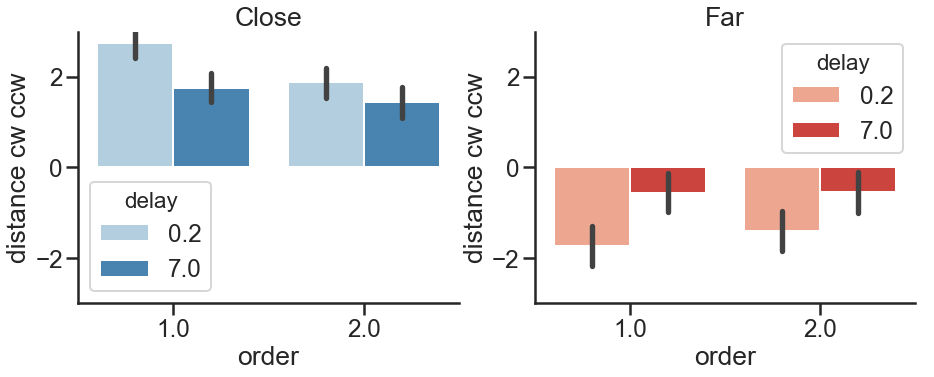

                  Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     distance_A_err
No. Observations:      6362        Method:                 REML          
No. Groups:            27          Scale:                  29.0392       
Min. group size:       107         Likelihood:             -19774.8987   
Max. group size:       354         Converged:              Yes           
Mean group size:       235.6                                             
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       3.627    0.428  8.474 0.000  2.788  4.466
dist_in_out[T.out]             -5.782    0.646 -8.945 0.000 -7.049 -4.515
delay                          -0.222    0.080 -2.758 0.006 -0.379 -0.064
delay:dist_in_out[T.out]        0.447    0.129  3.452 0.

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: distance_A_err
No. Observations: 3920    Method:             REML          
No. Groups:       27      Scale:              23.4243       
Min. group size:  73      Likelihood:         -11794.1352   
Max. group size:  181     Converged:          Yes           
Mean group size:  145.2                                     
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      3.528     0.561   6.285  0.000   2.428   4.628
delay         -0.216     0.072  -2.985  0.003  -0.357  -0.074
order         -0.849     0.228  -3.725  0.000  -1.295  -0.402
delay:order    0.083     0.046   1.831  0.067  -0.006   0.173
subject Var    4.981     0.296                               

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Var

In [7]:
fig = plt.figure()
fig.set_size_inches(15, 5)
fig.tight_layout()
#fig.suptitle('Order delay distance', fontsize=30)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.barplot( ax= ax1, x="order", y="distance_A_err", hue='delay', data=df_analysis.loc[df_analysis['dist_in_out']=='in'], palette='Blues')
sns.barplot( ax= ax2, x="order", y="distance_A_err", hue='delay', data=df_analysis.loc[df_analysis['dist_in_out']=='out'], palette='Reds')
axes=[ax1, ax2]
Titles=['Close', 'Far']

for i, Ax in enumerate(axes):
    Ax.spines['right'].set_visible(False)
    Ax.spines['top'].set_visible(False)
    Ax.title.set_text(Titles[i])
    #Ax.legend_.remove()
    #Ax.set_xticklabels(['in','out'])
    #Ax.set_xlabel('Distance T-Dist')
    Ax.set_ylabel('distance cw ccw')
    Ax.set_ylim(-3,3)

    
    


plt.show()

#Are the residuals normally distributed?
# sns.distplot(result.resid)
# plt.show()
# #Residuals distribution
# print(scipy.stats.anderson(x=result.resid, dist='norm'))
# #Residuals distribution
# print(scipy.stats.shapiro(result.resid))


result = smf.mixedlm(formula="distance_A_err ~ delay*order*dist_in_out ", data=df_analysis, groups='subject').fit()
print(result.summary())


result = smf.mixedlm(formula="distance_A_err ~ delay*order ", data=df_analysis.loc[ df_analysis['dist_in_out']=='in'], groups='subject').fit()
print(result.summary())


result = smf.mixedlm(formula="distance_A_err ~ delay*order ", data=df_analysis.loc[df_analysis['dist_in_out']=='out'], groups='subject').fit()
print(result.summary())


In [8]:
col_02 = '#457b9d'
col_7 = '#a82a33'

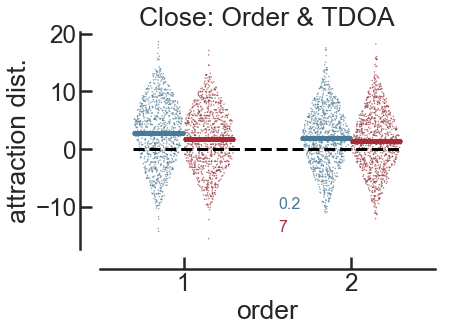

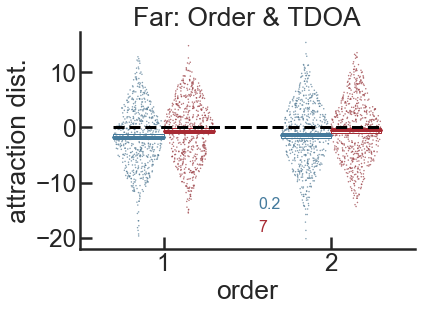

In [9]:
linares_plot(x='order', y='distance_A_err', hue='delay', df= df_analysis.loc[df_analysis['dist_in_out']=='in'], 
             palette= [col_02, col_7], 
              order=[1,2], hue_order=[0.2, 7], point_size=1.5, alpha=0.7, width=0.6 )  
#plt.ylim(-10,15)
plt.plot([-.3 ,1.3], [0,0], 'k--')
plt.ylabel('attraction dist.')
plt.title('Close: Order & TDOA')
plt.show(block=False)


linares_plot(x='order', y='distance_A_err', hue='delay', df= df_analysis.loc[df_analysis['dist_in_out']=='out'], 
             palette=[col_02, col_7], 
              order=[1,2], hue_order=[0.2, 7], point_size=1.5, alpha=0.7, width=0.6, sep_axis=False )  
#plt.ylim(-10,15)
plt.plot([-.3 ,1.3], [0,0], 'k--')
plt.ylabel('attraction dist.')
plt.title('Far: Order & TDOA')
plt.show(block=False)

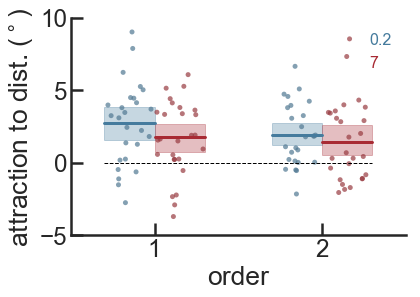

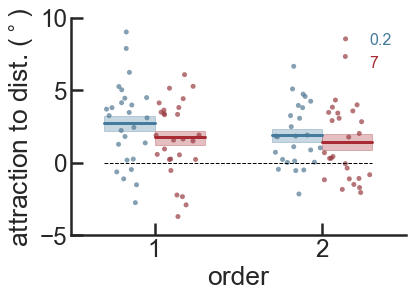

In [10]:
linares_plot(x='order', y='distance_A_err', hue='delay', df= df_analysis.loc[df_analysis['dist_in_out']=='in'], 
             palette=[col_02, col_7], order=[1,2], hue_order=[0.2, 7], point_size=5, 
             alpha=0.7, width=0.6, by_subj=True, subj_col='subject', reps=100,
            CI=0.95, loc_l=1, sep_axis=False, fill_box=True, alpha_box=0.3)  
plt.ylim(-5,10)
plt.plot([-.3 ,1.3], [0,0], 'k--', linewidth=1)
plt.ylabel(r'attraction to dist. ($^\circ$)');
#plt.title('close trials: SOA & order')
plt.show(block=False)



linares_plot(x='order', y='distance_A_err', hue='delay', df= df_analysis.loc[df_analysis['dist_in_out']=='in'], 
             palette=[col_02, col_7], order=[1,2], hue_order=[0.2, 7], point_size=5, 
             alpha=0.7, width=0.6, by_subj=True, subj_col='subject', reps=100,
            CI=0.68, loc_l=1, sep_axis=False, fill_box=True, alpha_box=0.3)  
plt.ylim(-5,10)
plt.plot([-.3 ,1.3], [0,0], 'k--', linewidth=1)
plt.ylabel(r'attraction to dist. ($^\circ$)');
#plt.title('close trials: SOA & order')
plt.show(block=False)




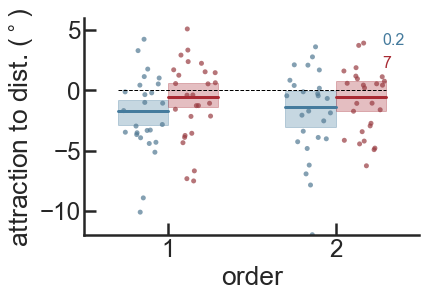

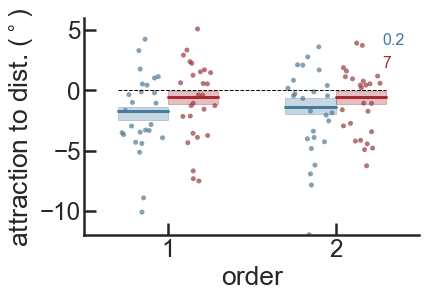

In [16]:
linares_plot(x='order', y='distance_A_err', hue='delay', df= df_analysis.loc[df_analysis['dist_in_out']=='out'], 
             palette=[col_02, col_7], order=[1,2], hue_order=[0.2, 7], point_size=5, 
             alpha=0.7, width=0.6, by_subj=True, subj_col='subject', reps=100,
            CI=0.95, loc_l=1, sep_axis=False, fill_box=True, alpha_box=0.3)  
plt.ylim(-12,6)
plt.plot([-.3 ,1.3], [0,0], 'k--', linewidth=1)
plt.ylabel(r'attraction to dist. ($^\circ$)');
#plt.title('close trials: SOA & order')
plt.show(block=False)



linares_plot(x='order', y='distance_A_err', hue='delay', df= df_analysis.loc[df_analysis['dist_in_out']=='out'], 
             palette=[col_02, col_7], order=[1,2], hue_order=[0.2, 7], point_size=5, 
             alpha=0.7, width=0.6, by_subj=True, subj_col='subject', reps=100,
            CI=0.68, loc_l=1, sep_axis=False, fill_box=True, alpha_box=0.3)  
plt.ylim(-12,6)
plt.plot([-.3 ,1.3], [0,0], 'k--', linewidth=1)
plt.ylabel(r'attraction to dist. ($^\circ$)');
#plt.title('close trials: SOA & order')
plt.show(block=False)


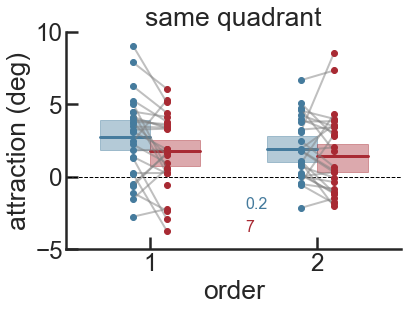

In [12]:
linares_plot( x="order", y="distance_A_err", hue='delay', 
             df=df_analysis.loc[df_analysis['dist_in_out']=='in'], 
             order=[1,2], hue_order=[0.2, 7], palette=[col_02, col_7],
            sep_axis=False, fill_box=True, alpha_box=0.4, by_subj=True, subj_col='subject',
            point_size=0, reps=100, CI=0.95)
plt.plot([-1,2], [0,0], '--k', linewidth=1)
plt.ylabel('attraction (deg)')
plt.ylim(-5,10)
plt.yticks([-5,0,5,10]);
plt.title('same quadrant')

inc_=-0.1
inc=0.1

for i in df_analysis.subject.unique():
    #######
    plt.plot([0+inc_,0+inc], 
             [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==0.2) & (df_analysis['order']==1) & (df_analysis['dist_in_out']=='in'), 'distance_A_err' ].mean(), 
              df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==7) & (df_analysis['order']==1) & (df_analysis['dist_in_out']=='in'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([0+inc_], [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==0.2) & (df_analysis['order']==1)& (df_analysis['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([0+inc], [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==7)& (df_analysis['order']==1)& (df_analysis['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )
    ########
    #######
    plt.plot([1+inc_,1+inc], 
             [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==0.2) & (df_analysis['order']==2) & (df_analysis['dist_in_out']=='in'), 'distance_A_err' ].mean(), 
              df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==7) & (df_analysis['order']==2) & (df_analysis['dist_in_out']=='in'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([1+inc_], [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==0.2) & (df_analysis['order']==2)& (df_analysis['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([1+inc], [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==7)& (df_analysis['order']==2)& (df_analysis['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )


In [13]:
result = smf.mixedlm(formula="distance_A_err ~ delay*order ", data=df_analysis.loc[ df_analysis['dist_in_out']=='in'], groups='subject').fit()
print(result.summary())

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: distance_A_err
No. Observations: 3920    Method:             REML          
No. Groups:       27      Scale:              23.4243       
Min. group size:  73      Likelihood:         -11794.1352   
Max. group size:  181     Converged:          Yes           
Mean group size:  145.2                                     
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      3.528     0.561   6.285  0.000   2.428   4.628
delay         -0.216     0.072  -2.985  0.003  -0.357  -0.074
order         -0.849     0.228  -3.725  0.000  -1.295  -0.402
delay:order    0.083     0.046   1.831  0.067  -0.006   0.173
subject Var    4.981     0.296                               



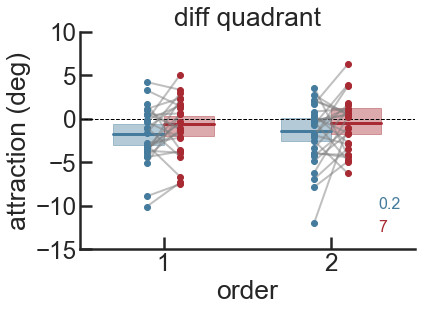

In [17]:
linares_plot( x="order", y="distance_A_err", hue='delay', 
             df=df_analysis.loc[df_analysis['dist_in_out']=='out'], 
             order=[1,2], hue_order=[0.2, 7], palette=[col_02, col_7],
            sep_axis=False, fill_box=True, alpha_box=0.4, by_subj=True, subj_col='subject',
            point_size=0, reps=100, CI=0.95)
plt.plot([-1,2], [0,0], '--k', linewidth=1)
plt.ylabel('attraction (deg)')
plt.ylim(-15,10)
plt.yticks([-15,-10,-5,0,5,10]);
plt.title('diff quadrant')

inc_=-0.1
inc=0.1

for i in df_analysis.subject.unique():
    #######
    plt.plot([0+inc_,0+inc], 
             [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==0.2) & (df_analysis['order']==1) & (df_analysis['dist_in_out']=='out'), 'distance_A_err' ].mean(), 
              df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==7) & (df_analysis['order']==1) & (df_analysis['dist_in_out']=='out'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([0+inc_], [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==0.2) & (df_analysis['order']==1)& (df_analysis['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([0+inc], [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==7)& (df_analysis['order']==1)& (df_analysis['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )
    ########
    #######
    plt.plot([1+inc_,1+inc], 
             [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==0.2) & (df_analysis['order']==2) & (df_analysis['dist_in_out']=='out'), 'distance_A_err' ].mean(), 
              df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==7) & (df_analysis['order']==2) & (df_analysis['dist_in_out']=='out'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([1+inc_], [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==0.2) & (df_analysis['order']==2)& (df_analysis['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([1+inc], [df_analysis.loc[(df_analysis['subject']==i) & (df_analysis['delay']==7)& (df_analysis['order']==2)& (df_analysis['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )


In [18]:
result = smf.mixedlm(formula="distance_A_err ~ delay*order ", data=df_analysis.loc[ df_analysis['dist_in_out']=='out'], groups='subject').fit()
print(result.summary())


result = smf.mixedlm(formula="distance_A_err ~ delay+order ", data=df_analysis.loc[ df_analysis['dist_in_out']=='out'], groups='subject').fit()
print(result.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: distance_A_err
No. Observations: 2442    Method:             REML          
No. Groups:       27      Scale:              26.2033       
Min. group size:  34      Likelihood:         -7496.7699    
Max. group size:  176     Converged:          Yes           
Mean group size:  90.4                                      
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept     -2.357     0.682  -3.456  0.001  -3.694  -1.020
delay          0.204     0.096   2.118  0.034   0.015   0.393
order          0.359     0.304   1.181  0.238  -0.237   0.955
delay:order   -0.048     0.061  -0.795  0.427  -0.168   0.071
subject Var    6.252     0.359                               

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Var

In [19]:
#### Just psychophysics

In [20]:
col_02 = 'b'
col_7 = 'orange'

df_psy = df_analysis.loc[df_analysis['environment']=='psychophysics']

In [21]:
result = smf.mixedlm(formula="distance_A_err ~ delay*order*dist_in_out", data=df_psy, 
                     groups='subject').fit()
print(result.summary())

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                  Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     distance_A_err
No. Observations:      4475        Method:                 REML          
No. Groups:            21          Scale:                  28.4820       
Min. group size:       107         Likelihood:             -13905.2907   
Max. group size:       223         Converged:              No            
Mean group size:       213.1                                             
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       4.106    1.252  3.279 0.001  1.652  6.560
dist_in_out[T.out]             -6.506    0.794 -8.190 0.000 -8.062 -4.949
delay                          -0.188    0.091 -2.058 0.040 -0.366 -0.009
delay:dist_in_out[T.out]        0.321    0.158  2.034 0.

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2026: ConvergenceWarning: Gradient optimization failed.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2066: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


In [ ]:
linares_plot( x="order", y="distance_A_err", hue='delay', 
             df=df_psy.loc[df_psy['dist_in_out']=='in'], 
             order=[1,2], hue_order=[0.2, 7], palette=[col_02, col_7],
            sep_axis=False, fill_box=True, alpha_box=0.4, by_subj=True, subj_col='subject',
            point_size=0, reps=100, CI=0.95)
plt.plot([-1,2], [0,0], '--k', linewidth=1)
plt.ylabel('attraction (deg)')
plt.ylim(-5,10)
plt.yticks([-5,0,5,10]);
plt.title('same quadrant')

inc_=-0.1
inc=0.1

for i in df_psy.subject.unique():
    #######
    plt.plot([0+inc_,0+inc], 
             [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==0.2) & (df_psy['order']==1) & (df_psy['dist_in_out']=='in'), 'distance_A_err' ].mean(), 
              df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==7) & (df_psy['order']==1) & (df_psy['dist_in_out']=='in'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([0+inc_], [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==0.2) & (df_psy['order']==1)& (df_psy['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([0+inc], [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==7)& (df_psy['order']==1)& (df_psy['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )
    ########
    #######
    plt.plot([1+inc_,1+inc], 
             [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==0.2) & (df_psy['order']==2) & (df_psy['dist_in_out']=='in'), 'distance_A_err' ].mean(), 
              df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==7) & (df_psy['order']==2) & (df_psy['dist_in_out']=='in'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([1+inc_], [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==0.2) & (df_psy['order']==2)& (df_psy['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([1+inc], [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==7)& (df_psy['order']==2)& (df_psy['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )


In [ ]:
result = smf.mixedlm(formula="distance_A_err ~ delay*order ", data=df_psy.loc[ df_psy['dist_in_out']=='in'], 
                     groups=df_psy.loc[ df_psy['dist_in_out']=='in','subject']).fit()
print(result.summary())

In [ ]:
linares_plot( x="order", y="distance_A_err", hue='delay', 
             df=df_psy.loc[df_psy['dist_in_out']=='out'], 
             order=[1,2], hue_order=[0.2, 7], palette=[col_02, col_7],
            sep_axis=False, fill_box=True, alpha_box=0.4, by_subj=True, subj_col='subject',
            point_size=0, reps=100, CI=0.95)
plt.plot([-1,2], [0,0], '--k', linewidth=1)
plt.ylabel('attraction (deg)')
plt.ylim(-15,10)
plt.yticks([-15,-10,-5,0,5,10]);
plt.title('diff quadrant')

inc_=-0.1
inc=0.1

for i in df_psy.subject.unique():
    #######
    plt.plot([0+inc_,0+inc], 
             [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==0.2) & (df_psy['order']==1) & (df_psy['dist_in_out']=='out'), 'distance_A_err' ].mean(), 
              df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==7) & (df_psy['order']==1) & (df_psy['dist_in_out']=='out'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([0+inc_], [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==0.2) & (df_psy['order']==1)& (df_psy['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([0+inc], [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==7)& (df_psy['order']==1)& (df_psy['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )
    ########
    #######
    plt.plot([1+inc_,1+inc], 
             [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==0.2) & (df_psy['order']==2) & (df_psy['dist_in_out']=='out'), 'distance_A_err' ].mean(), 
              df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==7) & (df_psy['order']==2) & (df_psy['dist_in_out']=='out'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([1+inc_], [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==0.2) & (df_psy['order']==2)& (df_psy['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([1+inc], [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==7)& (df_psy['order']==2)& (df_psy['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )


In [ ]:
result = smf.mixedlm(formula="distance_A_err ~ delay*order ", data=df_psy.loc[ df_psy['dist_in_out']=='out'], 
                     groups=df_psy.loc[ df_psy['dist_in_out']=='out','subject']).fit()
print(result.summary())

result = smf.mixedlm(formula="distance_A_err ~ delay+order ", data=df_psy.loc[ df_psy['dist_in_out']=='out'], 
                     groups=df_psy.loc[ df_psy['dist_in_out']=='out','subject']).fit()
print(result.summary())

In [ ]:
#### Just fMRI

In [ ]:
col_02 = 'b'
col_7 = 'orange'

df_psy = df_analysis.loc[df_analysis['environment']=='fMRI']

In [ ]:
result = smf.mixedlm(formula="distance_A_err ~ delay*order*dist_in_out", data=df_psy, 
                     groups='subject').fit()
print(result.summary())

In [ ]:
linares_plot( x="order", y="distance_A_err", hue='delay', 
             df=df_psy.loc[df_psy['dist_in_out']=='in'], 
             order=[1,2], hue_order=[0.2, 7], palette=[col_02, col_7],
            sep_axis=False, fill_box=True, alpha_box=0.4, by_subj=True, subj_col='subject',
            point_size=0, reps=100, CI=0.95)
plt.plot([-1,2], [0,0], '--k', linewidth=1)
plt.ylabel('attraction (deg)')
plt.ylim(-5,10)
plt.yticks([-5,0,5,10]);
plt.title('same quadrant')

inc_=-0.1
inc=0.1

for i in df_psy.subject.unique():
    #######
    plt.plot([0+inc_,0+inc], 
             [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==0.2) & (df_psy['order']==1) & (df_psy['dist_in_out']=='in'), 'distance_A_err' ].mean(), 
              df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==7) & (df_psy['order']==1) & (df_psy['dist_in_out']=='in'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([0+inc_], [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==0.2) & (df_psy['order']==1)& (df_psy['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([0+inc], [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==7)& (df_psy['order']==1)& (df_psy['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )
    ########
    #######
    plt.plot([1+inc_,1+inc], 
             [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==0.2) & (df_psy['order']==2) & (df_psy['dist_in_out']=='in'), 'distance_A_err' ].mean(), 
              df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==7) & (df_psy['order']==2) & (df_psy['dist_in_out']=='in'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([1+inc_], [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==0.2) & (df_psy['order']==2)& (df_psy['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([1+inc], [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==7)& (df_psy['order']==2)& (df_psy['dist_in_out']=='in'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )


In [ ]:
result = smf.mixedlm(formula="distance_A_err ~ delay*order ", data=df_psy.loc[ df_psy['dist_in_out']=='in'], 
                     groups=df_psy.loc[ df_psy['dist_in_out']=='in','subject']).fit()
print(result.summary())

In [ ]:
linares_plot( x="order", y="distance_A_err", hue='delay', 
             df=df_psy.loc[df_psy['dist_in_out']=='out'], 
             order=[1,2], hue_order=[0.2, 7], palette=[col_02, col_7],
            sep_axis=False, fill_box=True, alpha_box=0.4, by_subj=True, subj_col='subject',
            point_size=0, reps=100, CI=0.95)
plt.plot([-1,2], [0,0], '--k', linewidth=1)
plt.ylabel('attraction (deg)')
plt.ylim(-15,10)
plt.yticks([-15,-10,-5,0,5,10]);
plt.title('diff quadrant')

inc_=-0.1
inc=0.1

for i in df_psy.subject.unique():
    #######
    plt.plot([0+inc_,0+inc], 
             [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==0.2) & (df_psy['order']==1) & (df_psy['dist_in_out']=='out'), 'distance_A_err' ].mean(), 
              df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==7) & (df_psy['order']==1) & (df_psy['dist_in_out']=='out'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([0+inc_], [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==0.2) & (df_psy['order']==1)& (df_psy['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([0+inc], [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==7)& (df_psy['order']==1)& (df_psy['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )
    ########
    #######
    plt.plot([1+inc_,1+inc], 
             [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==0.2) & (df_psy['order']==2) & (df_psy['dist_in_out']=='out'), 'distance_A_err' ].mean(), 
              df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==7) & (df_psy['order']==2) & (df_psy['dist_in_out']=='out'), 'distance_A_err' ].mean()],
              '-', color='grey', linewidth=2, alpha=0.5)
    plt.plot([1+inc_], [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==0.2) & (df_psy['order']==2)& (df_psy['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_02, markersize=6 )
    plt.plot([1+inc], [df_psy.loc[(df_psy['subject']==i) & (df_psy['delay']==7)& (df_psy['order']==2)& (df_psy['dist_in_out']=='out'), 'distance_A_err' ].mean()], marker='o', color=col_7, markersize=6 )


In [ ]:
result = smf.mixedlm(formula="distance_A_err ~ delay*order ", data=df_psy.loc[ df_psy['dist_in_out']=='out'], 
                     groups=df_psy.loc[ df_psy['dist_in_out']=='out','subject']).fit()
print(result.summary())

result = smf.mixedlm(formula="distance_A_err ~ delay+order ", data=df_psy.loc[ df_psy['dist_in_out']=='out'], 
                     groups=df_psy.loc[ df_psy['dist_in_out']=='out','subject']).fit()
print(result.summary())

In [ ]:
## Distance

In [ ]:
linares_plot(x='type', y='distance_A_err', df= df_analysis, palette=['grey'], 
              order=[1,2,3],  point_size=1, alpha=0.4, width=0.6, sep_axis=False, 
             reps=100)  
#plt.ylim(2,8)
plt.title('Distance')
plt.plot([-.3 ,2.3], [0,0], 'k--')
plt.ylabel('distance error')
plt.xticks([0, 1, 2], ['10-20', '20-30', '40-180'], fontsize=20)
plt.xlabel('distance T-Dist (degrees)')
plt.show(block=False)



linares_plot(x='type', y='distance_A_err', df= df_analysis, palette=['grey'], 
              order=[1,2,3],  point_size=5, alpha=0.4, width=0.6, by_subj=True, subj_col='subject',
              reps=100, sep_axis=False)  
#plt.ylim(2,8)
plt.title('Distance')
plt.plot([-.3 ,2.3], [0,0], 'k--')
plt.ylabel('distance error')
plt.xticks([0, 1, 2], ['10-20', '20-30', '40-180'], fontsize=20)
plt.xlabel('distance T-Dist (degrees)')
plt.show(block=False)